In [135]:
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import numpy as np


import matplotlib.pyplot as plt

# Riparametrizzazione

In [292]:
x = torch.tensor([1,1,1]).float()

w1 = torch.randn((3,1),requires_grad=True).float()
w2 = torch.randn((3,1),requires_grad=True).float()
w3 = torch.randn(1,requires_grad=True).float()

mu = torch.sum(x*w1)
sigma = torch.sum(x*w2)

m = torch.distributions.normal.Normal(mu,sigma)
z = m.sample()

#eps = torch.randn(1)
#z = eps*sigma + mu

y = z*w3


In [293]:
print('dx/dw1: {}'.format(w1.grad))
print('dx/dw2: {}'.format(w2.grad))
print('dx/dw3: {}'.format(w3.grad))

dx/dw1: None
dx/dw2: None
dx/dw3: None


In [294]:
y.backward()

print('dx/dw1: {}'.format(w1.grad))
print('dx/dw2: {}'.format(w2.grad))
print('dx/dw3: {}'.format(w3.grad))

dx/dw1: None
dx/dw2: None
dx/dw3: tensor([3.3110])


# VAE

In [230]:
import torchvision
import torchvision.transforms as transforms


batch_size = 256
sample = 1


# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


if sample < 1:
    l = int(len(train_dataset)*sample)
    
    indexes = np.arange(len(train_dataset))
    np.random.shuffle(indexes)
    indexes = indexes[:l]
    
    train_sampler = SubsetRandomSampler(indexes)



# Data loader

if sample < 1:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [231]:

len(train_loader)

235

array([13771,  1585,  3531, ..., 58751, 16838, 45088])

In [232]:
def show_batch(batch,nrow=32):
    im = torchvision.utils.make_grid(batch,nrow)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.axis('off')
    

Labels:  tensor([0, 4, 0, 1, 3, 6, 0, 8, 9, 3, 2, 0, 8, 1, 9, 2, 0, 2, 7, 5, 5, 3, 5, 3,
        5, 9, 8, 3, 9, 1, 2, 8, 0, 9, 8, 6, 6, 0, 9, 9, 4, 4, 3, 7, 8, 7, 1, 1,
        5, 3, 9, 0, 0, 2, 3, 4, 4, 2, 7, 8, 4, 4, 0, 0, 1, 8, 1, 3, 9, 3, 2, 8,
        8, 1, 2, 2, 4, 1, 3, 1, 7, 5, 7, 0, 4, 3, 9, 5, 2, 3, 0, 2, 2, 0, 1, 6,
        7, 0, 1, 1, 3, 2, 3, 4, 7, 7, 1, 8, 5, 5, 9, 3, 6, 4, 9, 1, 5, 3, 6, 9,
        6, 6, 8, 1, 3, 7, 2, 4, 1, 8, 0, 6, 0, 5, 9, 3, 9, 9, 3, 6, 9, 2, 7, 6,
        2, 9, 3, 2, 1, 9, 9, 4, 3, 4, 8, 2, 7, 2, 5, 6, 0, 1, 2, 3, 2, 6, 0, 2,
        3, 0, 5, 4, 4, 7, 1, 1, 5, 0, 6, 7, 3, 2, 6, 5, 4, 0, 5, 6, 3, 8, 0, 8,
        4, 2, 7, 7, 2, 7, 1, 5, 7, 7, 1, 3, 0, 9, 7, 0, 0, 2, 4, 1, 1, 8, 5, 2,
        9, 6, 5, 6, 1, 1, 2, 9, 1, 8, 7, 3, 3, 6, 2, 0, 5, 8, 4, 5, 9, 7, 6, 9,
        0, 0, 8, 5, 1, 1, 1, 8, 3, 7, 5, 2, 9, 0, 2, 0])
Batch shape:  torch.Size([256, 1, 28, 28])


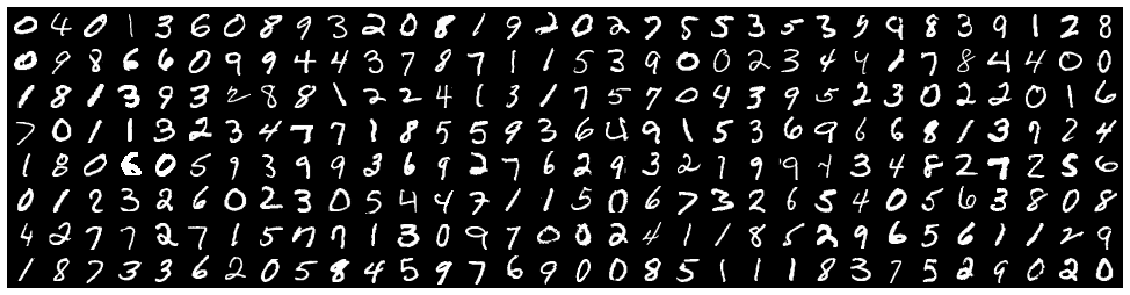

In [233]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())

plt.figure(figsize=(20,20))

show_batch(images)

In [240]:
class VAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, ):
        super(VAE, self).__init__()

        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        
        self.init_weights()        
        

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            nn.init.xavier_normal_(layer.weight)

        for layer in self.p_layers:
            nn.init.xavier_normal_(layer.weight)
        
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar
    
    
    def encode(self, input):
        h = input
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.relu(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu)


    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.relu(h)

        return F.sigmoid(h)

    
    def generate(self,n_samples=1):
        
        with torch.no_grad():
            z = torch.randn((n_samples,self.p_dims[0]))
            return self.decode(z)

In [241]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [263]:
learning_rate = 0.0001
log_interval = 10

seed = 12356
torch.manual_seed(seed)


model = VAE(p_dims=[2,256,784])
criterion = loss_function

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 200

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

In [264]:
# The number of steps for each epoch, defined by the number of instances divided by the batch size. 
total_step = len(train_loader)

def train(epoch,model,criterion,optimizer,reshape=True):
    for batch_idx, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        if reshape:
            images = images.reshape(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, mu, logvar = model(images)
        loss = criterion(outputs, images, mu, logvar)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % log_interval == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        
        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))

        
def test(model,criterion,reshape=True):
    test_loss = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            if reshape:
                images = images.reshape(-1, 28*28)
                
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, mu, logvar = model(images)
            loss = criterion(outputs, images, mu, logvar) 
            
            test_loss += loss.item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))

In [265]:

for epoch in range(1,num_epochs+1):
    train(epoch,model,criterion,optimizer)
    test(model,criterion)

Epoch [1/200], Step [10/235], Loss: 138346.5469
Epoch [1/200], Step [20/235], Loss: 135226.6250
Epoch [1/200], Step [30/235], Loss: 132167.2812
Epoch [1/200], Step [40/235], Loss: 128597.1094
Epoch [1/200], Step [50/235], Loss: 124359.3359
Epoch [1/200], Step [60/235], Loss: 118873.4141
Epoch [1/200], Step [70/235], Loss: 112065.6719
Epoch [1/200], Step [80/235], Loss: 105545.9297
Epoch [1/200], Step [90/235], Loss: 100285.6250
Epoch [1/200], Step [100/235], Loss: 94888.8203
Epoch [1/200], Step [110/235], Loss: 90136.1250
Epoch [1/200], Step [120/235], Loss: 85617.3359
Epoch [1/200], Step [130/235], Loss: 82215.7266
Epoch [1/200], Step [140/235], Loss: 80087.7031
Epoch [1/200], Step [150/235], Loss: 77847.5547
Epoch [1/200], Step [160/235], Loss: 77124.0625
Epoch [1/200], Step [170/235], Loss: 74213.2578
Epoch [1/200], Step [180/235], Loss: 73759.8828
Epoch [1/200], Step [190/235], Loss: 72074.5938
Epoch [1/200], Step [200/235], Loss: 71453.9609
Epoch [1/200], Step [210/235], Loss: 703

Epoch [8/200], Step [80/235], Loss: 47539.5039
Epoch [8/200], Step [90/235], Loss: 48527.3477
Epoch [8/200], Step [100/235], Loss: 49006.0664
Epoch [8/200], Step [110/235], Loss: 47645.5352
Epoch [8/200], Step [120/235], Loss: 48640.3438
Epoch [8/200], Step [130/235], Loss: 48007.1602
Epoch [8/200], Step [140/235], Loss: 48038.8594
Epoch [8/200], Step [150/235], Loss: 48286.5156
Epoch [8/200], Step [160/235], Loss: 47281.4375
Epoch [8/200], Step [170/235], Loss: 48164.4844
Epoch [8/200], Step [180/235], Loss: 47855.9141
Epoch [8/200], Step [190/235], Loss: 46320.9023
Epoch [8/200], Step [200/235], Loss: 47001.4258
Epoch [8/200], Step [210/235], Loss: 47536.1289
Epoch [8/200], Step [220/235], Loss: 48028.0703
Epoch [8/200], Step [230/235], Loss: 47696.5977

Test set: Avg. loss: 186.0218

Epoch [9/200], Step [10/235], Loss: 48333.9219
Epoch [9/200], Step [20/235], Loss: 46825.5586
Epoch [9/200], Step [30/235], Loss: 46974.1797
Epoch [9/200], Step [40/235], Loss: 47761.0352
Epoch [9/200],

Epoch [15/200], Step [120/235], Loss: 45619.0469
Epoch [15/200], Step [130/235], Loss: 43862.7930
Epoch [15/200], Step [140/235], Loss: 45239.7422
Epoch [15/200], Step [150/235], Loss: 44287.9062
Epoch [15/200], Step [160/235], Loss: 45703.7891
Epoch [15/200], Step [170/235], Loss: 44497.2031
Epoch [15/200], Step [180/235], Loss: 44345.8359
Epoch [15/200], Step [190/235], Loss: 45282.6484
Epoch [15/200], Step [200/235], Loss: 45899.2500
Epoch [15/200], Step [210/235], Loss: 44818.8125
Epoch [15/200], Step [220/235], Loss: 46524.2734
Epoch [15/200], Step [230/235], Loss: 44029.6602

Test set: Avg. loss: 175.9371

Epoch [16/200], Step [10/235], Loss: 46153.1367
Epoch [16/200], Step [20/235], Loss: 45044.0703
Epoch [16/200], Step [30/235], Loss: 44452.9453
Epoch [16/200], Step [40/235], Loss: 45725.9180
Epoch [16/200], Step [50/235], Loss: 44215.2539
Epoch [16/200], Step [60/235], Loss: 43757.1211
Epoch [16/200], Step [70/235], Loss: 45855.6172
Epoch [16/200], Step [80/235], Loss: 44644.4

Epoch [22/200], Step [150/235], Loss: 44442.7227
Epoch [22/200], Step [160/235], Loss: 43503.3477
Epoch [22/200], Step [170/235], Loss: 43995.6289
Epoch [22/200], Step [180/235], Loss: 43628.3438
Epoch [22/200], Step [190/235], Loss: 42921.1484
Epoch [22/200], Step [200/235], Loss: 43906.3789
Epoch [22/200], Step [210/235], Loss: 43931.7031
Epoch [22/200], Step [220/235], Loss: 44714.8828
Epoch [22/200], Step [230/235], Loss: 45159.9453

Test set: Avg. loss: 170.5122

Epoch [23/200], Step [10/235], Loss: 44494.9336
Epoch [23/200], Step [20/235], Loss: 43249.2578
Epoch [23/200], Step [30/235], Loss: 44615.9648
Epoch [23/200], Step [40/235], Loss: 44675.3359
Epoch [23/200], Step [50/235], Loss: 43501.5859
Epoch [23/200], Step [60/235], Loss: 43192.4922
Epoch [23/200], Step [70/235], Loss: 44574.3867
Epoch [23/200], Step [80/235], Loss: 43895.5469
Epoch [23/200], Step [90/235], Loss: 44505.1797
Epoch [23/200], Step [100/235], Loss: 43426.2422
Epoch [23/200], Step [110/235], Loss: 42517.94

Epoch [29/200], Step [180/235], Loss: 43550.0625
Epoch [29/200], Step [190/235], Loss: 42856.1406
Epoch [29/200], Step [200/235], Loss: 42239.9414
Epoch [29/200], Step [210/235], Loss: 42438.3281
Epoch [29/200], Step [220/235], Loss: 43687.6836
Epoch [29/200], Step [230/235], Loss: 42180.6016

Test set: Avg. loss: 167.5642

Epoch [30/200], Step [10/235], Loss: 43706.7383
Epoch [30/200], Step [20/235], Loss: 42451.4805
Epoch [30/200], Step [30/235], Loss: 42189.2773
Epoch [30/200], Step [40/235], Loss: 42829.1367
Epoch [30/200], Step [50/235], Loss: 41690.3945
Epoch [30/200], Step [60/235], Loss: 43758.4688
Epoch [30/200], Step [70/235], Loss: 42780.0078
Epoch [30/200], Step [80/235], Loss: 43377.8984
Epoch [30/200], Step [90/235], Loss: 41494.8711
Epoch [30/200], Step [100/235], Loss: 43071.4102
Epoch [30/200], Step [110/235], Loss: 42901.6953
Epoch [30/200], Step [120/235], Loss: 42661.2031
Epoch [30/200], Step [130/235], Loss: 42750.3906
Epoch [30/200], Step [140/235], Loss: 43780.83

Epoch [36/200], Step [210/235], Loss: 43067.7227
Epoch [36/200], Step [220/235], Loss: 42296.2617
Epoch [36/200], Step [230/235], Loss: 40186.3438

Test set: Avg. loss: 165.7639

Epoch [37/200], Step [10/235], Loss: 43885.7305
Epoch [37/200], Step [20/235], Loss: 41832.2695
Epoch [37/200], Step [30/235], Loss: 41126.1367
Epoch [37/200], Step [40/235], Loss: 43086.4531
Epoch [37/200], Step [50/235], Loss: 41597.9258
Epoch [37/200], Step [60/235], Loss: 41385.5039
Epoch [37/200], Step [70/235], Loss: 42974.2812
Epoch [37/200], Step [80/235], Loss: 42289.6133
Epoch [37/200], Step [90/235], Loss: 41616.2891
Epoch [37/200], Step [100/235], Loss: 42557.9688
Epoch [37/200], Step [110/235], Loss: 40873.0664
Epoch [37/200], Step [120/235], Loss: 42422.0938
Epoch [37/200], Step [130/235], Loss: 41269.8164
Epoch [37/200], Step [140/235], Loss: 42998.9648
Epoch [37/200], Step [150/235], Loss: 41464.2305
Epoch [37/200], Step [160/235], Loss: 41602.8320
Epoch [37/200], Step [170/235], Loss: 42922.07


Test set: Avg. loss: 164.5766

Epoch [44/200], Step [10/235], Loss: 41752.9414
Epoch [44/200], Step [20/235], Loss: 42334.7812
Epoch [44/200], Step [30/235], Loss: 42488.1602
Epoch [44/200], Step [40/235], Loss: 40500.5234
Epoch [44/200], Step [50/235], Loss: 42089.6797
Epoch [44/200], Step [60/235], Loss: 42053.3242
Epoch [44/200], Step [70/235], Loss: 41732.3711
Epoch [44/200], Step [80/235], Loss: 41489.7578
Epoch [44/200], Step [90/235], Loss: 41947.0820
Epoch [44/200], Step [100/235], Loss: 41143.0547
Epoch [44/200], Step [110/235], Loss: 41771.1367
Epoch [44/200], Step [120/235], Loss: 40926.8203
Epoch [44/200], Step [130/235], Loss: 42124.2773
Epoch [44/200], Step [140/235], Loss: 41886.0664
Epoch [44/200], Step [150/235], Loss: 41904.4648
Epoch [44/200], Step [160/235], Loss: 42090.0469
Epoch [44/200], Step [170/235], Loss: 42299.3438
Epoch [44/200], Step [180/235], Loss: 42188.7305
Epoch [44/200], Step [190/235], Loss: 41296.0820
Epoch [44/200], Step [200/235], Loss: 42113.75

Epoch [51/200], Step [40/235], Loss: 41955.5078
Epoch [51/200], Step [50/235], Loss: 42548.8438
Epoch [51/200], Step [60/235], Loss: 42301.1445
Epoch [51/200], Step [70/235], Loss: 39523.1445
Epoch [51/200], Step [80/235], Loss: 41856.1680
Epoch [51/200], Step [90/235], Loss: 41754.7383
Epoch [51/200], Step [100/235], Loss: 42158.3516
Epoch [51/200], Step [110/235], Loss: 42049.3594
Epoch [51/200], Step [120/235], Loss: 41060.8477
Epoch [51/200], Step [130/235], Loss: 41523.3086
Epoch [51/200], Step [140/235], Loss: 41957.9961
Epoch [51/200], Step [150/235], Loss: 41483.8047
Epoch [51/200], Step [160/235], Loss: 42772.1445
Epoch [51/200], Step [170/235], Loss: 42089.4727
Epoch [51/200], Step [180/235], Loss: 42128.2422
Epoch [51/200], Step [190/235], Loss: 41927.8203
Epoch [51/200], Step [200/235], Loss: 41462.7578
Epoch [51/200], Step [210/235], Loss: 40790.9414
Epoch [51/200], Step [220/235], Loss: 41334.2773
Epoch [51/200], Step [230/235], Loss: 41536.2344

Test set: Avg. loss: 163.

Epoch [58/200], Step [70/235], Loss: 41353.8594
Epoch [58/200], Step [80/235], Loss: 42840.1172
Epoch [58/200], Step [90/235], Loss: 41348.0664
Epoch [58/200], Step [100/235], Loss: 39026.9648
Epoch [58/200], Step [110/235], Loss: 41489.6328
Epoch [58/200], Step [120/235], Loss: 40853.0820
Epoch [58/200], Step [130/235], Loss: 41355.4531
Epoch [58/200], Step [140/235], Loss: 40857.8398
Epoch [58/200], Step [150/235], Loss: 41583.6328
Epoch [58/200], Step [160/235], Loss: 42041.1953
Epoch [58/200], Step [170/235], Loss: 40621.9531
Epoch [58/200], Step [180/235], Loss: 41572.2148
Epoch [58/200], Step [190/235], Loss: 40706.6719
Epoch [58/200], Step [200/235], Loss: 40854.7188
Epoch [58/200], Step [210/235], Loss: 42598.2695
Epoch [58/200], Step [220/235], Loss: 40777.1328
Epoch [58/200], Step [230/235], Loss: 41964.1172

Test set: Avg. loss: 162.4937

Epoch [59/200], Step [10/235], Loss: 41994.7734
Epoch [59/200], Step [20/235], Loss: 40662.9805
Epoch [59/200], Step [30/235], Loss: 41410

Epoch [65/200], Step [100/235], Loss: 41936.6484
Epoch [65/200], Step [110/235], Loss: 40126.8789
Epoch [65/200], Step [120/235], Loss: 41684.8477
Epoch [65/200], Step [130/235], Loss: 41965.4922
Epoch [65/200], Step [140/235], Loss: 39677.3750
Epoch [65/200], Step [150/235], Loss: 40595.8008
Epoch [65/200], Step [160/235], Loss: 40275.7539
Epoch [65/200], Step [170/235], Loss: 42314.8594
Epoch [65/200], Step [180/235], Loss: 41761.8320
Epoch [65/200], Step [190/235], Loss: 40833.6367
Epoch [65/200], Step [200/235], Loss: 42408.0312
Epoch [65/200], Step [210/235], Loss: 41775.3086
Epoch [65/200], Step [220/235], Loss: 40378.6719
Epoch [65/200], Step [230/235], Loss: 40062.6094

Test set: Avg. loss: 161.7610

Epoch [66/200], Step [10/235], Loss: 40036.1875
Epoch [66/200], Step [20/235], Loss: 40571.3359
Epoch [66/200], Step [30/235], Loss: 42041.4453
Epoch [66/200], Step [40/235], Loss: 41153.2031
Epoch [66/200], Step [50/235], Loss: 40066.8164
Epoch [66/200], Step [60/235], Loss: 42180

Epoch [72/200], Step [130/235], Loss: 40304.0000
Epoch [72/200], Step [140/235], Loss: 40545.7109
Epoch [72/200], Step [150/235], Loss: 41309.5820
Epoch [72/200], Step [160/235], Loss: 40235.2305
Epoch [72/200], Step [170/235], Loss: 41098.8828
Epoch [72/200], Step [180/235], Loss: 40577.6367
Epoch [72/200], Step [190/235], Loss: 39466.5391
Epoch [72/200], Step [200/235], Loss: 41014.6680
Epoch [72/200], Step [210/235], Loss: 41309.4727
Epoch [72/200], Step [220/235], Loss: 41511.9258
Epoch [72/200], Step [230/235], Loss: 40627.3438

Test set: Avg. loss: 161.0129

Epoch [73/200], Step [10/235], Loss: 42121.1289
Epoch [73/200], Step [20/235], Loss: 41080.2812
Epoch [73/200], Step [30/235], Loss: 40223.2969
Epoch [73/200], Step [40/235], Loss: 41216.3477
Epoch [73/200], Step [50/235], Loss: 41558.7656
Epoch [73/200], Step [60/235], Loss: 40392.3594
Epoch [73/200], Step [70/235], Loss: 40013.0273
Epoch [73/200], Step [80/235], Loss: 40895.1094
Epoch [73/200], Step [90/235], Loss: 40714.90

Epoch [79/200], Step [160/235], Loss: 40160.2422
Epoch [79/200], Step [170/235], Loss: 39289.0547
Epoch [79/200], Step [180/235], Loss: 41063.9766
Epoch [79/200], Step [190/235], Loss: 41500.7461
Epoch [79/200], Step [200/235], Loss: 39867.0547
Epoch [79/200], Step [210/235], Loss: 41534.2852
Epoch [79/200], Step [220/235], Loss: 42024.9180
Epoch [79/200], Step [230/235], Loss: 41163.1250

Test set: Avg. loss: 160.4346

Epoch [80/200], Step [10/235], Loss: 39460.3281
Epoch [80/200], Step [20/235], Loss: 40796.7305
Epoch [80/200], Step [30/235], Loss: 39750.8125
Epoch [80/200], Step [40/235], Loss: 42064.8164
Epoch [80/200], Step [50/235], Loss: 41944.3477
Epoch [80/200], Step [60/235], Loss: 43438.7227
Epoch [80/200], Step [70/235], Loss: 41258.0352
Epoch [80/200], Step [80/235], Loss: 40438.8828
Epoch [80/200], Step [90/235], Loss: 40372.8398
Epoch [80/200], Step [100/235], Loss: 40101.2461
Epoch [80/200], Step [110/235], Loss: 40347.0273
Epoch [80/200], Step [120/235], Loss: 40142.14

Epoch [86/200], Step [190/235], Loss: 40147.4453
Epoch [86/200], Step [200/235], Loss: 41206.8945
Epoch [86/200], Step [210/235], Loss: 40690.5469
Epoch [86/200], Step [220/235], Loss: 40112.0781
Epoch [86/200], Step [230/235], Loss: 41290.7969

Test set: Avg. loss: 159.8869

Epoch [87/200], Step [10/235], Loss: 39640.5547
Epoch [87/200], Step [20/235], Loss: 39870.2461
Epoch [87/200], Step [30/235], Loss: 40561.0039
Epoch [87/200], Step [40/235], Loss: 42195.0469
Epoch [87/200], Step [50/235], Loss: 39274.9453
Epoch [87/200], Step [60/235], Loss: 40099.0547
Epoch [87/200], Step [70/235], Loss: 41064.3047
Epoch [87/200], Step [80/235], Loss: 39566.8945
Epoch [87/200], Step [90/235], Loss: 40520.4453
Epoch [87/200], Step [100/235], Loss: 41035.9141
Epoch [87/200], Step [110/235], Loss: 40752.5078
Epoch [87/200], Step [120/235], Loss: 40424.6875
Epoch [87/200], Step [130/235], Loss: 41161.4492
Epoch [87/200], Step [140/235], Loss: 40879.9922
Epoch [87/200], Step [150/235], Loss: 39920.66

Epoch [93/200], Step [220/235], Loss: 40429.4297
Epoch [93/200], Step [230/235], Loss: 41123.4688

Test set: Avg. loss: 159.3702

Epoch [94/200], Step [10/235], Loss: 41165.3398
Epoch [94/200], Step [20/235], Loss: 40310.8164
Epoch [94/200], Step [30/235], Loss: 40295.5508
Epoch [94/200], Step [40/235], Loss: 39306.8672
Epoch [94/200], Step [50/235], Loss: 40498.2422
Epoch [94/200], Step [60/235], Loss: 41774.6484
Epoch [94/200], Step [70/235], Loss: 40864.4336
Epoch [94/200], Step [80/235], Loss: 40896.2070
Epoch [94/200], Step [90/235], Loss: 40867.6016
Epoch [94/200], Step [100/235], Loss: 42230.7383
Epoch [94/200], Step [110/235], Loss: 40407.1484
Epoch [94/200], Step [120/235], Loss: 39818.2812
Epoch [94/200], Step [130/235], Loss: 40373.1719
Epoch [94/200], Step [140/235], Loss: 41409.0781
Epoch [94/200], Step [150/235], Loss: 41160.7305
Epoch [94/200], Step [160/235], Loss: 40959.6914
Epoch [94/200], Step [170/235], Loss: 40692.2812
Epoch [94/200], Step [180/235], Loss: 39914.91

Epoch [101/200], Step [10/235], Loss: 40253.7422
Epoch [101/200], Step [20/235], Loss: 40379.8477
Epoch [101/200], Step [30/235], Loss: 40778.7344
Epoch [101/200], Step [40/235], Loss: 40689.5781
Epoch [101/200], Step [50/235], Loss: 40616.5781
Epoch [101/200], Step [60/235], Loss: 40816.8906
Epoch [101/200], Step [70/235], Loss: 39702.8320
Epoch [101/200], Step [80/235], Loss: 40547.0312
Epoch [101/200], Step [90/235], Loss: 39627.8828
Epoch [101/200], Step [100/235], Loss: 40433.2617
Epoch [101/200], Step [110/235], Loss: 41482.6641
Epoch [101/200], Step [120/235], Loss: 40378.9727
Epoch [101/200], Step [130/235], Loss: 39361.3828
Epoch [101/200], Step [140/235], Loss: 40151.7852
Epoch [101/200], Step [150/235], Loss: 40736.5078
Epoch [101/200], Step [160/235], Loss: 40133.0039
Epoch [101/200], Step [170/235], Loss: 40152.0352
Epoch [101/200], Step [180/235], Loss: 40103.5469
Epoch [101/200], Step [190/235], Loss: 39852.7656
Epoch [101/200], Step [200/235], Loss: 40517.9258
Epoch [10

Epoch [108/200], Step [10/235], Loss: 41086.5938
Epoch [108/200], Step [20/235], Loss: 40939.5625
Epoch [108/200], Step [30/235], Loss: 40388.5820
Epoch [108/200], Step [40/235], Loss: 38056.3750
Epoch [108/200], Step [50/235], Loss: 40217.1680
Epoch [108/200], Step [60/235], Loss: 40130.4258
Epoch [108/200], Step [70/235], Loss: 39884.6836
Epoch [108/200], Step [80/235], Loss: 40409.9258
Epoch [108/200], Step [90/235], Loss: 41017.5156
Epoch [108/200], Step [100/235], Loss: 40777.3945
Epoch [108/200], Step [110/235], Loss: 40941.2969
Epoch [108/200], Step [120/235], Loss: 41545.3398
Epoch [108/200], Step [130/235], Loss: 40691.9727
Epoch [108/200], Step [140/235], Loss: 41283.9688
Epoch [108/200], Step [150/235], Loss: 39634.5391
Epoch [108/200], Step [160/235], Loss: 39782.6016
Epoch [108/200], Step [170/235], Loss: 40512.2148
Epoch [108/200], Step [180/235], Loss: 39996.9688
Epoch [108/200], Step [190/235], Loss: 42091.2852
Epoch [108/200], Step [200/235], Loss: 39231.1719
Epoch [10

Epoch [115/200], Step [10/235], Loss: 38580.6562
Epoch [115/200], Step [20/235], Loss: 39537.5742
Epoch [115/200], Step [30/235], Loss: 40129.9102
Epoch [115/200], Step [40/235], Loss: 40100.0742
Epoch [115/200], Step [50/235], Loss: 41478.0117
Epoch [115/200], Step [60/235], Loss: 40450.1094
Epoch [115/200], Step [70/235], Loss: 39699.3047
Epoch [115/200], Step [80/235], Loss: 38980.1719
Epoch [115/200], Step [90/235], Loss: 39637.8945
Epoch [115/200], Step [100/235], Loss: 40810.9531
Epoch [115/200], Step [110/235], Loss: 41004.7070
Epoch [115/200], Step [120/235], Loss: 39415.2344
Epoch [115/200], Step [130/235], Loss: 39955.2773
Epoch [115/200], Step [140/235], Loss: 40307.0469
Epoch [115/200], Step [150/235], Loss: 39893.1641
Epoch [115/200], Step [160/235], Loss: 40094.2812
Epoch [115/200], Step [170/235], Loss: 40268.7969
Epoch [115/200], Step [180/235], Loss: 39297.2188
Epoch [115/200], Step [190/235], Loss: 40321.1875
Epoch [115/200], Step [200/235], Loss: 40439.5117
Epoch [11

Epoch [122/200], Step [10/235], Loss: 40235.8711
Epoch [122/200], Step [20/235], Loss: 39748.1953
Epoch [122/200], Step [30/235], Loss: 39596.7539
Epoch [122/200], Step [40/235], Loss: 38885.1992
Epoch [122/200], Step [50/235], Loss: 40047.3438
Epoch [122/200], Step [60/235], Loss: 40208.0000
Epoch [122/200], Step [70/235], Loss: 39283.9688
Epoch [122/200], Step [80/235], Loss: 39942.5898
Epoch [122/200], Step [90/235], Loss: 40431.2852
Epoch [122/200], Step [100/235], Loss: 39867.7656
Epoch [122/200], Step [110/235], Loss: 39462.0156
Epoch [122/200], Step [120/235], Loss: 40768.2070
Epoch [122/200], Step [130/235], Loss: 39447.4648
Epoch [122/200], Step [140/235], Loss: 40545.2969
Epoch [122/200], Step [150/235], Loss: 39037.3789
Epoch [122/200], Step [160/235], Loss: 40359.5898
Epoch [122/200], Step [170/235], Loss: 40542.9844
Epoch [122/200], Step [180/235], Loss: 39783.3086
Epoch [122/200], Step [190/235], Loss: 40449.5664
Epoch [122/200], Step [200/235], Loss: 39816.9180
Epoch [12

Epoch [129/200], Step [10/235], Loss: 39770.4648
Epoch [129/200], Step [20/235], Loss: 40535.0547
Epoch [129/200], Step [30/235], Loss: 40396.4844
Epoch [129/200], Step [40/235], Loss: 41449.2500
Epoch [129/200], Step [50/235], Loss: 40452.8945
Epoch [129/200], Step [60/235], Loss: 40698.0469
Epoch [129/200], Step [70/235], Loss: 40780.8203
Epoch [129/200], Step [80/235], Loss: 40067.5039
Epoch [129/200], Step [90/235], Loss: 40315.6953
Epoch [129/200], Step [100/235], Loss: 39928.0703
Epoch [129/200], Step [110/235], Loss: 41241.0234
Epoch [129/200], Step [120/235], Loss: 39949.1836
Epoch [129/200], Step [130/235], Loss: 39192.7070
Epoch [129/200], Step [140/235], Loss: 39593.6719
Epoch [129/200], Step [150/235], Loss: 39856.8047
Epoch [129/200], Step [160/235], Loss: 39648.9961
Epoch [129/200], Step [170/235], Loss: 41744.5039
Epoch [129/200], Step [180/235], Loss: 38935.0664
Epoch [129/200], Step [190/235], Loss: 39505.5508
Epoch [129/200], Step [200/235], Loss: 41147.3789
Epoch [12

Epoch [136/200], Step [10/235], Loss: 40638.8047
Epoch [136/200], Step [20/235], Loss: 40203.7539
Epoch [136/200], Step [30/235], Loss: 40014.4531
Epoch [136/200], Step [40/235], Loss: 39605.3711
Epoch [136/200], Step [50/235], Loss: 39603.7617
Epoch [136/200], Step [60/235], Loss: 39013.0820
Epoch [136/200], Step [70/235], Loss: 39451.8594
Epoch [136/200], Step [80/235], Loss: 38869.9688
Epoch [136/200], Step [90/235], Loss: 39866.7812
Epoch [136/200], Step [100/235], Loss: 40151.5898
Epoch [136/200], Step [110/235], Loss: 39968.7656
Epoch [136/200], Step [120/235], Loss: 39769.1836
Epoch [136/200], Step [130/235], Loss: 39638.8984
Epoch [136/200], Step [140/235], Loss: 39307.7070
Epoch [136/200], Step [150/235], Loss: 39574.3516
Epoch [136/200], Step [160/235], Loss: 39249.3477
Epoch [136/200], Step [170/235], Loss: 39353.7812
Epoch [136/200], Step [180/235], Loss: 39829.3359
Epoch [136/200], Step [190/235], Loss: 39243.2422
Epoch [136/200], Step [200/235], Loss: 37896.7266
Epoch [13

Epoch [143/200], Step [10/235], Loss: 38762.4141
Epoch [143/200], Step [20/235], Loss: 39776.6055
Epoch [143/200], Step [30/235], Loss: 40768.2070
Epoch [143/200], Step [40/235], Loss: 40208.0898
Epoch [143/200], Step [50/235], Loss: 39791.6523
Epoch [143/200], Step [60/235], Loss: 39886.3203
Epoch [143/200], Step [70/235], Loss: 39263.8789
Epoch [143/200], Step [80/235], Loss: 41994.2188
Epoch [143/200], Step [90/235], Loss: 38938.6055
Epoch [143/200], Step [100/235], Loss: 39459.1055
Epoch [143/200], Step [110/235], Loss: 40547.5352
Epoch [143/200], Step [120/235], Loss: 39528.7812
Epoch [143/200], Step [130/235], Loss: 40973.7930
Epoch [143/200], Step [140/235], Loss: 39670.1953
Epoch [143/200], Step [150/235], Loss: 37654.0039
Epoch [143/200], Step [160/235], Loss: 40903.9688
Epoch [143/200], Step [170/235], Loss: 40782.9180
Epoch [143/200], Step [180/235], Loss: 39083.0664
Epoch [143/200], Step [190/235], Loss: 39505.6797
Epoch [143/200], Step [200/235], Loss: 40263.2539
Epoch [14

Epoch [150/200], Step [10/235], Loss: 39000.9961
Epoch [150/200], Step [20/235], Loss: 39886.9258
Epoch [150/200], Step [30/235], Loss: 39599.3945
Epoch [150/200], Step [40/235], Loss: 39219.4961
Epoch [150/200], Step [50/235], Loss: 40650.1289
Epoch [150/200], Step [60/235], Loss: 39699.5430
Epoch [150/200], Step [70/235], Loss: 40301.2266
Epoch [150/200], Step [80/235], Loss: 40608.6484
Epoch [150/200], Step [90/235], Loss: 38890.2500
Epoch [150/200], Step [100/235], Loss: 39319.6562
Epoch [150/200], Step [110/235], Loss: 39542.7969
Epoch [150/200], Step [120/235], Loss: 38951.1367
Epoch [150/200], Step [130/235], Loss: 37456.7695
Epoch [150/200], Step [140/235], Loss: 40060.0781
Epoch [150/200], Step [150/235], Loss: 40326.3008
Epoch [150/200], Step [160/235], Loss: 39425.1797
Epoch [150/200], Step [170/235], Loss: 39095.6641
Epoch [150/200], Step [180/235], Loss: 39013.1914
Epoch [150/200], Step [190/235], Loss: 40589.3711
Epoch [150/200], Step [200/235], Loss: 38327.4844
Epoch [15

Epoch [157/200], Step [10/235], Loss: 39469.2734
Epoch [157/200], Step [20/235], Loss: 40590.2500
Epoch [157/200], Step [30/235], Loss: 39514.1094
Epoch [157/200], Step [40/235], Loss: 41013.7188
Epoch [157/200], Step [50/235], Loss: 38724.3398
Epoch [157/200], Step [60/235], Loss: 40176.6211
Epoch [157/200], Step [70/235], Loss: 40020.3438
Epoch [157/200], Step [80/235], Loss: 39974.6055
Epoch [157/200], Step [90/235], Loss: 40195.6641
Epoch [157/200], Step [100/235], Loss: 39527.5430
Epoch [157/200], Step [110/235], Loss: 39320.9297
Epoch [157/200], Step [120/235], Loss: 39390.3359
Epoch [157/200], Step [130/235], Loss: 38581.4570
Epoch [157/200], Step [140/235], Loss: 39828.4531
Epoch [157/200], Step [150/235], Loss: 40510.6953
Epoch [157/200], Step [160/235], Loss: 39725.5781
Epoch [157/200], Step [170/235], Loss: 39775.9336
Epoch [157/200], Step [180/235], Loss: 39363.7812
Epoch [157/200], Step [190/235], Loss: 39644.9023
Epoch [157/200], Step [200/235], Loss: 39731.1719
Epoch [15

Epoch [164/200], Step [10/235], Loss: 38156.8203
Epoch [164/200], Step [20/235], Loss: 40112.5312
Epoch [164/200], Step [30/235], Loss: 39531.4570
Epoch [164/200], Step [40/235], Loss: 39738.2031
Epoch [164/200], Step [50/235], Loss: 40201.1211
Epoch [164/200], Step [60/235], Loss: 39169.6016
Epoch [164/200], Step [70/235], Loss: 39941.6523
Epoch [164/200], Step [80/235], Loss: 39337.8438
Epoch [164/200], Step [90/235], Loss: 38713.0742
Epoch [164/200], Step [100/235], Loss: 41047.0820
Epoch [164/200], Step [110/235], Loss: 38557.7383
Epoch [164/200], Step [120/235], Loss: 39023.6836
Epoch [164/200], Step [130/235], Loss: 39303.6719
Epoch [164/200], Step [140/235], Loss: 39845.1641
Epoch [164/200], Step [150/235], Loss: 37258.9727
Epoch [164/200], Step [160/235], Loss: 39442.0742
Epoch [164/200], Step [170/235], Loss: 40812.5234
Epoch [164/200], Step [180/235], Loss: 39075.3906
Epoch [164/200], Step [190/235], Loss: 39651.6484
Epoch [164/200], Step [200/235], Loss: 40010.9766
Epoch [16

Epoch [171/200], Step [10/235], Loss: 38737.6289
Epoch [171/200], Step [20/235], Loss: 37894.3633
Epoch [171/200], Step [30/235], Loss: 39995.6992
Epoch [171/200], Step [40/235], Loss: 40578.5586
Epoch [171/200], Step [50/235], Loss: 40133.9258
Epoch [171/200], Step [60/235], Loss: 39284.6992
Epoch [171/200], Step [70/235], Loss: 40665.2109
Epoch [171/200], Step [80/235], Loss: 38051.6641
Epoch [171/200], Step [90/235], Loss: 39289.2227
Epoch [171/200], Step [100/235], Loss: 39777.9531
Epoch [171/200], Step [110/235], Loss: 40001.8242
Epoch [171/200], Step [120/235], Loss: 40738.3750
Epoch [171/200], Step [130/235], Loss: 38808.8086
Epoch [171/200], Step [140/235], Loss: 38484.8594
Epoch [171/200], Step [150/235], Loss: 39677.7969
Epoch [171/200], Step [160/235], Loss: 38748.8789
Epoch [171/200], Step [170/235], Loss: 39490.9062
Epoch [171/200], Step [180/235], Loss: 39029.1875
Epoch [171/200], Step [190/235], Loss: 39444.0547
Epoch [171/200], Step [200/235], Loss: 39613.1914
Epoch [17

Epoch [178/200], Step [10/235], Loss: 39245.6484
Epoch [178/200], Step [20/235], Loss: 37864.8555
Epoch [178/200], Step [30/235], Loss: 39233.9336
Epoch [178/200], Step [40/235], Loss: 39944.4375
Epoch [178/200], Step [50/235], Loss: 38418.5664
Epoch [178/200], Step [60/235], Loss: 39810.2070
Epoch [178/200], Step [70/235], Loss: 39680.6094
Epoch [178/200], Step [80/235], Loss: 38307.4336
Epoch [178/200], Step [90/235], Loss: 39891.8438
Epoch [178/200], Step [100/235], Loss: 39339.7891
Epoch [178/200], Step [110/235], Loss: 38029.6523
Epoch [178/200], Step [120/235], Loss: 39548.8047
Epoch [178/200], Step [130/235], Loss: 39035.9336
Epoch [178/200], Step [140/235], Loss: 38577.3242
Epoch [178/200], Step [150/235], Loss: 39605.8086
Epoch [178/200], Step [160/235], Loss: 39875.3438
Epoch [178/200], Step [170/235], Loss: 39552.9375
Epoch [178/200], Step [180/235], Loss: 40509.2734
Epoch [178/200], Step [190/235], Loss: 39281.1172
Epoch [178/200], Step [200/235], Loss: 39770.4141
Epoch [17

Epoch [185/200], Step [10/235], Loss: 39864.1953
Epoch [185/200], Step [20/235], Loss: 39063.1133
Epoch [185/200], Step [30/235], Loss: 38497.2109
Epoch [185/200], Step [40/235], Loss: 39416.6094
Epoch [185/200], Step [50/235], Loss: 39678.7812
Epoch [185/200], Step [60/235], Loss: 39066.4023
Epoch [185/200], Step [70/235], Loss: 39023.5781
Epoch [185/200], Step [80/235], Loss: 40308.6211
Epoch [185/200], Step [90/235], Loss: 39246.5195
Epoch [185/200], Step [100/235], Loss: 39792.1523
Epoch [185/200], Step [110/235], Loss: 39976.1797
Epoch [185/200], Step [120/235], Loss: 38903.8633
Epoch [185/200], Step [130/235], Loss: 39581.0430
Epoch [185/200], Step [140/235], Loss: 39345.2266
Epoch [185/200], Step [150/235], Loss: 40311.3086
Epoch [185/200], Step [160/235], Loss: 39124.8711
Epoch [185/200], Step [170/235], Loss: 40661.3047
Epoch [185/200], Step [180/235], Loss: 39567.1953
Epoch [185/200], Step [190/235], Loss: 40749.3125
Epoch [185/200], Step [200/235], Loss: 39336.7031
Epoch [18

Epoch [192/200], Step [10/235], Loss: 39129.0625
Epoch [192/200], Step [20/235], Loss: 40039.2539
Epoch [192/200], Step [30/235], Loss: 39244.7148
Epoch [192/200], Step [40/235], Loss: 38877.0703
Epoch [192/200], Step [50/235], Loss: 39408.5508
Epoch [192/200], Step [60/235], Loss: 39463.1094
Epoch [192/200], Step [70/235], Loss: 39773.0547
Epoch [192/200], Step [80/235], Loss: 38472.1602
Epoch [192/200], Step [90/235], Loss: 38604.8125
Epoch [192/200], Step [100/235], Loss: 39201.7188
Epoch [192/200], Step [110/235], Loss: 39474.5938
Epoch [192/200], Step [120/235], Loss: 38612.5117
Epoch [192/200], Step [130/235], Loss: 39439.9180
Epoch [192/200], Step [140/235], Loss: 39282.2461
Epoch [192/200], Step [150/235], Loss: 38516.7500
Epoch [192/200], Step [160/235], Loss: 38167.2500
Epoch [192/200], Step [170/235], Loss: 39999.1758
Epoch [192/200], Step [180/235], Loss: 38388.1094
Epoch [192/200], Step [190/235], Loss: 39112.9023
Epoch [192/200], Step [200/235], Loss: 41331.6875
Epoch [19

Epoch [199/200], Step [10/235], Loss: 38935.7148
Epoch [199/200], Step [20/235], Loss: 40038.7500
Epoch [199/200], Step [30/235], Loss: 38808.5312
Epoch [199/200], Step [40/235], Loss: 39167.0352
Epoch [199/200], Step [50/235], Loss: 40549.6992
Epoch [199/200], Step [60/235], Loss: 38789.5938
Epoch [199/200], Step [70/235], Loss: 40200.1445
Epoch [199/200], Step [80/235], Loss: 38999.4023
Epoch [199/200], Step [90/235], Loss: 39922.3555
Epoch [199/200], Step [100/235], Loss: 38273.8008
Epoch [199/200], Step [110/235], Loss: 39496.9609
Epoch [199/200], Step [120/235], Loss: 37905.7891
Epoch [199/200], Step [130/235], Loss: 38827.4219
Epoch [199/200], Step [140/235], Loss: 38792.3633
Epoch [199/200], Step [150/235], Loss: 39807.1016
Epoch [199/200], Step [160/235], Loss: 40281.2656
Epoch [199/200], Step [170/235], Loss: 39545.0430
Epoch [199/200], Step [180/235], Loss: 38667.4922
Epoch [199/200], Step [190/235], Loss: 38818.6133
Epoch [199/200], Step [200/235], Loss: 40997.8672
Epoch [19

Batch shape:  torch.Size([100, 1, 28, 28])


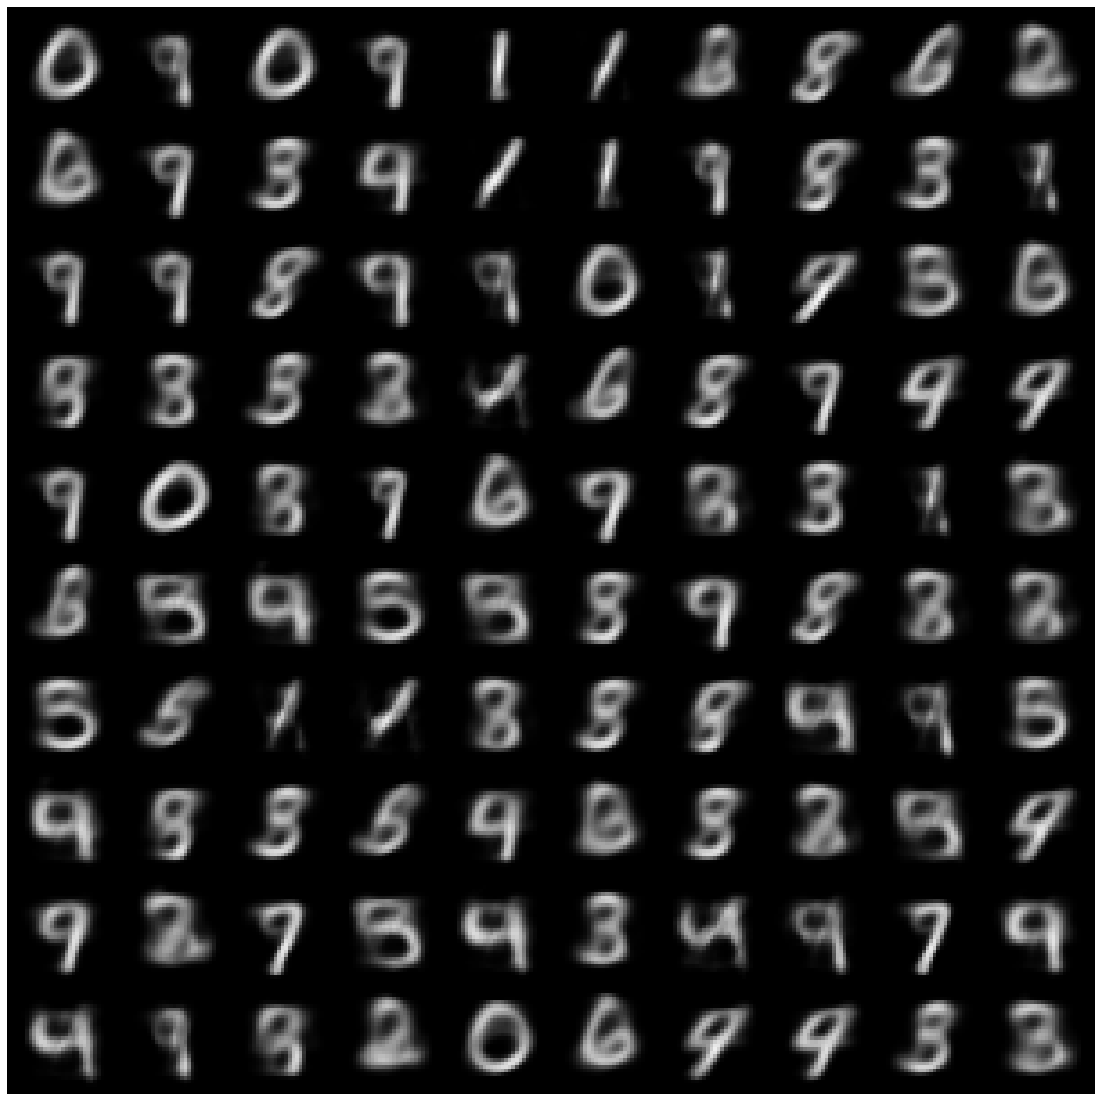

In [267]:
images = model.generate(100)

images = images.view(-1,1,28,28)

print('Batch shape: ', images.size())

plt.figure(figsize=(20,20))

show_batch(images,nrow=10)

In [159]:
images.shape

torch.Size([10, 28, 28])